In [1]:
import torch
import os
import numpy as np
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
from IPython import display

In [2]:
# 数据集
X = torch.tensor([
   [0.0, 0],
   [0, 1],
   [1, 0],
   [1, 1],
])
Y = torch.tensor(
 [[0.0],
 [1],
 [1],
 [0]]
)
Y = Y.squeeze()
X.shape, Y.shape

(torch.Size([4, 2]), torch.Size([4]))

In [3]:
# 建立模型，为了练习效果，此处不套用nn.Linear与CrossEntryLoss，采取手写模型与损失函数，仅使用torch的自动求梯度功能
def caculate_loss(y, y_hat):
    l = -torch.log(y_hat[int(y.item())])
    
    return l

class Krxk_model():
    # 不继承 nn.Module,采用原始手写
    def __init__(self, lr=0.1): 
        self.w1 = torch.normal(0, 1, (2, 100), requires_grad=True)
        self.b1 = torch.zeros((100), requires_grad=True)
        self.w2 = torch.normal(0, 1, (100, 2), requires_grad=True)
        self.b2 = torch.zeros((2), requires_grad=True)
        self.lr = lr
    def forward(self, x):
        y_hat = torch.matmul(x, self.w1) + self.b1
        y_hat = self.Relu(y_hat)
        y_hat = torch.matmul(y_hat, self.w2) + self.b2
        
        y_hat = self.SoftMax(y_hat)
        return y_hat
    def Relu(self, x):
        x =  (x > torch.zeros_like(x))*torch.ones_like(x)*x
        return x
    def SoftMax(self, X):
        X_exp = torch.exp(X)
        partition = X_exp.sum(0, keepdim=True)
        return X_exp/partition
    def zero_grad(self):
        self.w1.grad.zero_()
        self.w2.grad.zero_()
        self.b1.grad.zero_()
        self.b2.grad.zero_()
    def step(self):
        with torch.no_grad():
            self.w1 -= self.w1.grad*self.lr
            self.w2 -= self.w2.grad*self.lr
            self.b1 -= self.b1.grad*self.lr
            self.b2 -= self.b2.grad*self.lr
        self.zero_grad()
    def state_dict(self):
        return {'w1':self.w1,'w2':self.w2,'b1':self.b1,'b2':self.b2}

In [4]:
# 定义模型与超参数
lr = 1e-1
model = Krxk_model(lr=lr)

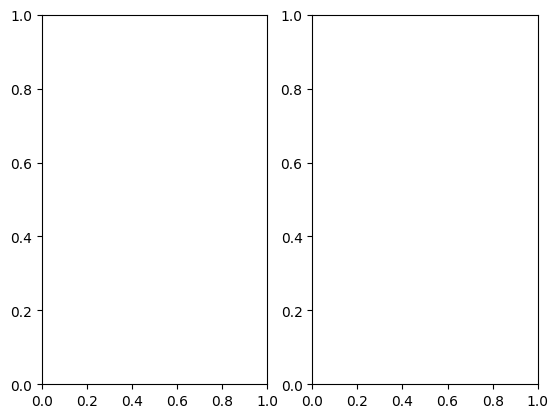

In [5]:
# 初始化绘图环境
fig, axes = plt.subplots(1, 2)

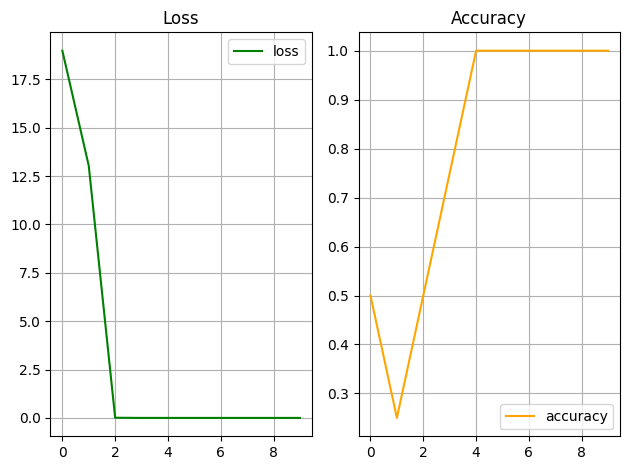

Epoch 9 Loss: 0.00012446223990991712
Epoch 9 Accuracy: 1.0
Finished


In [6]:
%time
epochs = 10

epoch_loss = []
accuracy = []

sample_cap = X.shape[0]
for epoch in range(epochs):
    pre_true = 0
    pre_total = 0
    for sample_num in range(sample_cap):
        x, y = X[sample_num], Y[sample_num]
        y_hat = model.forward(x)
        
        # 计算精确度
        pre_label = y_hat.argmax(dim=0)
        pre_true += ((pre_label == y)* torch.ones_like(y)).mean()
        pre_total += 1
        
        l = caculate_loss(y, y_hat)

        l.backward()
        model.step()
    
    epoch_loss.append(l.cpu().detach().numpy())
    accuracy.append((pre_true/pre_total).cpu().detach().numpy())
    
    for ax in axes:
        ax.cla() # 清空绘图缓存
        
    axes[0].plot(range(epoch+1), epoch_loss, 'green',label='loss')
    axes[1].plot(range(epoch+1), accuracy, 'orange',label='accuracy')
    display.clear_output(wait=True) # 清空上一步输出

    axes[0].set_title('Loss')
    axes[1].set_title('Accuracy')
    for ax in axes:
        ax.grid()
        ax.legend()

    fig.tight_layout()
    display.display(fig)
    
    print(f'Epoch {epoch} Loss: {l}')
    print(f'Epoch {epoch} Accuracy: {accuracy[-1]}')

print('Finished')

In [7]:
# 保存
torch.save(model.state_dict(), './hw_2-XOR.bin')